## What's the manual implentation of cross-entropy?

`F.cross_entropy` takes mean nll loss of entire sequence, not just last index.
So a Transformer is tested on its accuracy for _every_ word, not just the last.


In [ ]:
import torch
import torch.nn.functional as F

logits = torch.tensor([[100, 0], [0, 0]], dtype=torch.float32)
targets = torch.tensor([0, 0], dtype=torch.long)

F.cross_entropy(logits, targets, ignore_index=-1)

In [ ]:
def cross_entropy(logits, targets, ignore_index=-1):
    """manual implementation of cross entropy loss"""
    log_probs = F.log_softmax(logits, dim=-1)
    targets = targets.view(-1, 1)
    ignore_mask = targets == ignore_index
    targets = torch.where(ignore_mask, torch.zeros_like(targets), targets)
    targets = targets.view(-1)
    nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1))
    nll_loss = torch.where(ignore_mask, torch.zeros_like(nll_loss), nll_loss)
    return nll_loss.mean()


cross_entropy(logits, targets, ignore_index=-1)

# What's the q-perplexity (quantised)?

Comparing across many models and step sizes. softermax does takes a softer blow to ppl than OG softmax -- good news!

Method: run `train.py` on eval mode, compute ppl metrics. then dynamically quantize model, and repeat. `eval.py` has config.


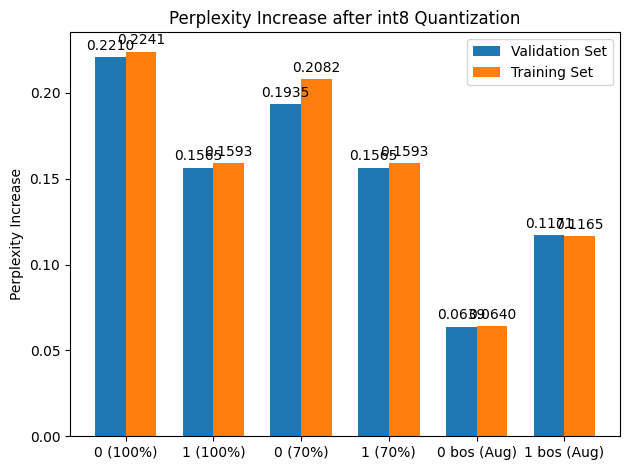

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# New data provided
data = {
    "0 (100%)": {
        "val": 3.0539,
        "train": 2.9941,
        "qval": 3.2749,
        "qtrain": 3.2182,
    },
    "1 (100%)": {
        "val": 3.0399,
        "train": 2.9785,
        "qval": 3.1964,
        "qtrain": 3.1378,
    },
    "0 (70%)": {
        "val": 3.1264,
        "train": 3.0369,
        "qval": 3.3199,
        "qtrain": 3.2451,
    },
    "1 (70%)": {
        "val": 3.0399,
        "train": 2.9786,
        "qval": 3.1964,
        "qtrain": 3.1379,
    },
    "0 bos (Aug)": {"val": 3.9195, "train": 3.828, "qval": 3.9834, "qtrain": 3.892},
    "1 bos (Aug)": {
        "val": 3.9692,
        "train": 3.9212,
        "qval": 4.0863,
        "qtrain": 4.0377,
    },
}


# Abstracted method to calculate perplexity increase
def calculate_ppl_increase(data):
    pplinc = {}
    for model, metrics in data.items():
        pplinc[model] = {
            "val": metrics["qval"] - metrics["val"],
            "train": metrics["qtrain"] - metrics["train"],
        }
    return pplinc


# Using the abstracted method
pplinc_new = calculate_ppl_increase(data)

# Preparing data for plotting
labels_new = list(pplinc_new.keys())
val_increases_new = [pplinc_new[model]["val"] for model in labels_new]
train_increases_new = [pplinc_new[model]["train"] for model in labels_new]

# Plotting
x_new = np.arange(len(labels_new))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1_new = ax.bar(x_new - width / 2, val_increases_new,
                    width, label="Validation Set")
rects2_new = ax.bar(x_new + width / 2, train_increases_new,
                    width, label="Training Set")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Perplexity Increase")
ax.set_title("Perplexity Increase after int8 Quantization")
ax.set_xticks(x_new)
ax.set_xticklabels(labels_new)
ax.legend()


# Function to attach a label on each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.4f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1_new)
autolabel(rects2_new)

fig.tight_layout()

plt.show()